The cell below imports a number of useful functions (including `numpy`).

In [1]:
%pylab inline
from scipy.optimize import curve_fit
sys.path.append('methods/')
import sum_exp_methods as sem

# !pip install BioPython
from Bio import Phylo
from io import StringIO
# import ete3

Populating the interactive namespace from numpy and matplotlib


The following cell may require installation of some python packages.
They are useful for visualization but not important for the simulations themselves

# Run Simulation

Below we define a function which, given an array of coefficients and correlation lengths, returns $$D(l) = \sum_i a_i(1-e^{-l/\xi_i})$$


In [2]:
def sum_exp(x,*params):
    L = len(params)
    assert L%2==0
    coeffs = params[:L//2]
    lens = params[L//2:]
    return sum([coeffs[i]*(1-exp(-x/l)) for i,l in enumerate(lens)],axis=0)

## Sum of exponentials fit to power law
Here we show that one can approximate a power law quite well over orders of magnitude, using just $k=3$ exponentials, with parameters fit using the `curve_fit` function. However in the rest of the notebook we just use a combination of additive and independent pieces for the fitness landscape.

[41.81070719  5.75605985  2.91375032]
[1260.83786537   89.56067016    6.25576697]


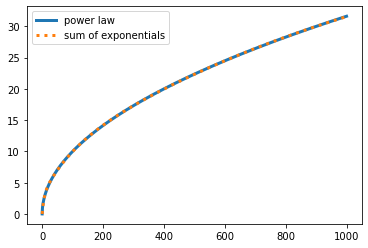

In [3]:
xfit = linspace(0,1000,1000)
alpha = .5
y = xfit**alpha
k = 3 # number of exponentials
popt,_ = curve_fit(sum_exp,xfit,y,p0=ones(2*k))

L = len(popt)
coeff_list = popt[:L//2]
corr_len_list = popt[L//2:]
print(coeff_list)
print(corr_len_list)

plot(xfit,y,label='power law',linewidth=3)
plot(xfit,sum_exp(xfit,*popt),label='sum of exponentials',linewidth=3,linestyle='dotted')
legend()

## Sum of Additive and Independent
Here we explore the combination of an additive landscape and a simple exponential. We put in the exponential piece by having the landscape determined by a very small correlation length $D(l) = a(1-e^{-l/\xi})$ with $\xi\to0$. On top of this we have an additive piece with mean $0$ and tunable variance.

We see that our simulations can handle up to a few thousand genoypes alive at any given instant. The parameters that control this are $N$, the population size and $U$ the overall mutation rate.

In [4]:
%%time
N = 100000 # population size
U = 1e-3 # mutation rate
add = .15 # variance of the additive piece; mean is 0
ind = .6 # strength of independent piece
eps = .001 # correlation length of independent piece (taken to be very small)

RE = sem.RandomEvoExp(N,U,ind*ones(1),eps*ones(1),seed=2,additive=add)
RE.run_evo(1000)

CPU times: user 9.22 s, sys: 226 ms, total: 9.44 s
Wall time: 13.2 s


Text(0, 0.5, 'mean fitness')

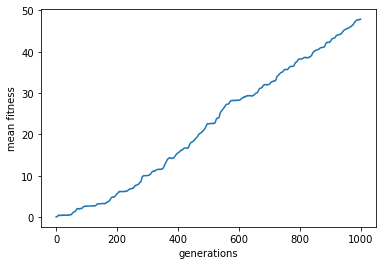

In [5]:
plot(RE.mean_fitness)
xlabel('generations')
ylabel('mean fitness')

Text(0, 0.5, 'number of extant genotypes')

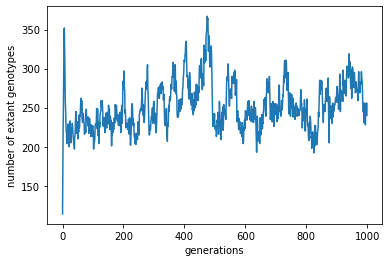

In [6]:
plot(RE.num_active_classes)
xlabel('generations')
ylabel('number of extant genotypes')

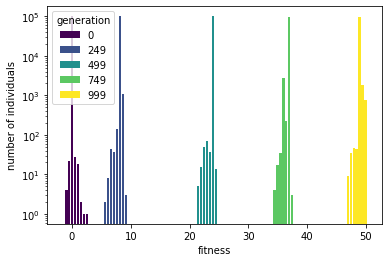

In [7]:
cmap = mpl.cm.get_cmap('viridis')
norm = mpl.colors.Normalize(vmin=0, vmax=len(RE.s_dist_traj))

for ii in linspace(0,len(RE.s_dist_traj)-1,5):
    dist = RE.s_dist_traj[int(ii)] # s distribution
    x = array([j for j in dist]) # fitness
    y = array([dist[j] for j in dist]) # number of individuals
    
    xbins = arange(min(x),max(x)+.5,.5)
    binned = digitize(x,xbins)
    ybinned = [sum(y[binned==k]) for k in range(len(xbins))]
    bar(xbins,ybinned,width=.4,color=cmap(norm(ii)),label=int(ii))
yscale('log')
xlabel('fitness')
ylabel('number of individuals')
legend(title='generation')

# Visualization
We can visualize a phylogeny of the genotypes. At any point a vertical cut will intersect all the genotypes alive at that moment in time. The tree becomes very bushy very quickly, so we have done some pruning of short-lived genotypes for ease of plotting and visualization.

The cell below generates a pdf image of the phylogeny of the genotypes generated by simulation.

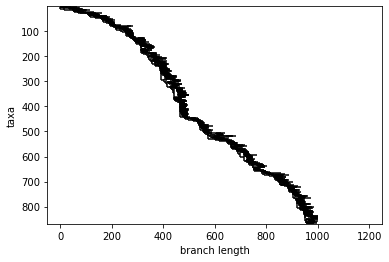

In [8]:
sys.setrecursionlimit(10**5)
tree_string = RE.get_reduced_newick(15,mutations=False)
handle = StringIO(tree_string)
T = Phylo.read(handle,'newick')
T.ladderize()

Phylo.draw(T,label_func=lambda x:None,branch_labels=lambda x:None)

# Vary relative strength of adaptive and independent part
We can vary the variance of the independent part of the landscape and see how this changes the dynamics of evolution. The larger this variance, the slower we expect adaptation to be. The additive part of the landscape has fixed variance throughout.

In [9]:
%%time
N = 1000
U = 1e-3
add = .1
ind_array = arange(0,1,.2)

mf = []

for ind in ind_array:
    RE = sem.RandomEvoExp(N,U,ind*ones(1),.001*ones(1),seed=5,additive=add)
    RE.run_evo(5000)
    mf.append(RE.mean_fitness)

CPU times: user 11.4 s, sys: 172 ms, total: 11.6 s
Wall time: 14.7 s


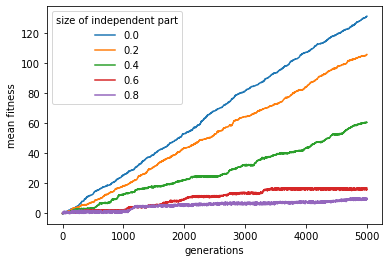

In [10]:
for i,f in enumerate(mf):
    plot(f,label=round(ind_array[i],2))
xlabel('generations')
ylabel('mean fitness')
legend(title='size of independent part')